In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio as rio

from pathlib import Path
from osgeo import gdal
from pyproj import Proj, Transformer
from rasterio import plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.interpolate import RegularGridInterpolator

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

# Get top surface grain sizes from SoilGrids

### Catchment DEM

Get the DEM of the catchment to get the bounds of the catchment so that the grain size from inside the catchment is used.

In [2]:
path_to_tif = Path('./tet/')

In [3]:
dem_asc = path_to_tif/'dem_200m_preproc.asc'
nx, ny, geotransform, dem = cp.asc2numpy(str(dem_asc))

In [4]:
ul = (geotransform[0], geotransform[3])
lr = (geotransform[0] + nx * geotransform[1], geotransform[3] + ny * geotransform[5])
ll = (geotransform[0], geotransform[3] + ny * geotransform[5])

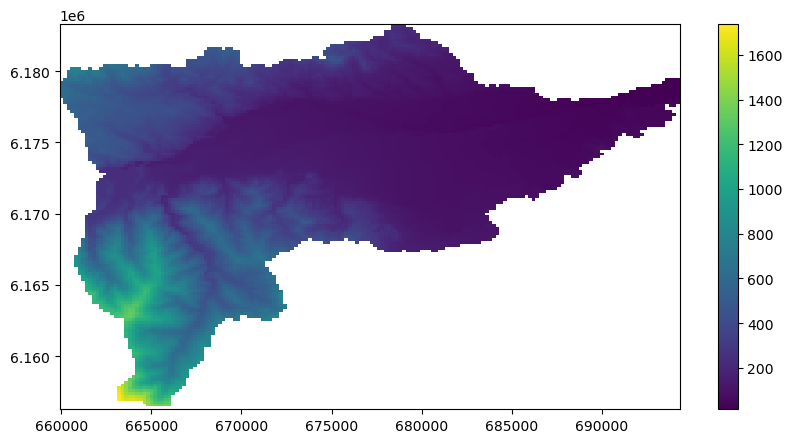

In [5]:
dx = geotransform[1]

x = np.linspace(ll[0], ll[0] + dx * (nx -1), nx)
y = np.linspace(ll[1] + dx * (ny -1), ll[1], ny)
X,Y = np.meshgrid(x, y, indexing='xy')

plt.figure(figsize=[10,5])
plt.subplot(111)
plt.pcolormesh(X, Y, dem)
plt.colorbar()
plt.show()

### Coordinate transformation

Transform the coordinates to WGS84 as it is easier to work with when pulling the SoilGirds tiles

In [6]:
pr = Proj('+proj=igh +datum=WGS84 +no_defs +towgs84=0,0,0', preserve_units=False)

In [7]:
transproj = Transformer.from_crs('EPSG:2154', '+proj=igh +datum=WGS84 +no_defs +towgs84=0,0,0', always_xy=True)

In [8]:
x = np.zeros((2,))
y = np.zeros((2,))
for i, pt in enumerate(transproj.itransform([ul, lr])):
    x[i], y[i] = pt
    print('{:.3f} {:.3f}'.format(*pt))

1066108.535 4757498.186
1095387.648 4730891.452


### Get the SoilGrids tile(s) for the same region

Will use the SoilGrids model output to estimate the grain size proportions. See these examples: https://git.wur.nl/isric/soilgrids/soilgrids.notebooks/-/tree/master. Start with the `silt.map` layer:

In [9]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/silt.map',
                         version='2.0.1')

For the SoilGrids projection see: https://www.isric.org/explore/soilgrids/faq-soilgrids#How_can_I_use_the_Homolosine_projection

Look at SoilGrid silt layers

In [10]:
print(list(wcs.contents))

['silt_0-5cm_Q0.05', 'silt_0-5cm_Q0.5', 'silt_0-5cm_Q0.95', 'silt_0-5cm_mean', 'silt_0-5cm_uncertainty', 'silt_5-15cm_Q0.05', 'silt_5-15cm_Q0.5', 'silt_5-15cm_Q0.95', 'silt_5-15cm_mean', 'silt_5-15cm_uncertainty', 'silt_15-30cm_Q0.05', 'silt_15-30cm_Q0.5', 'silt_15-30cm_Q0.95', 'silt_15-30cm_mean', 'silt_15-30cm_uncertainty', 'silt_30-60cm_Q0.5', 'silt_30-60cm_Q0.05', 'silt_30-60cm_Q0.95', 'silt_30-60cm_mean', 'silt_30-60cm_uncertainty', 'silt_60-100cm_Q0.05', 'silt_60-100cm_Q0.5', 'silt_60-100cm_Q0.95', 'silt_60-100cm_mean', 'silt_60-100cm_uncertainty', 'silt_100-200cm_Q0.5', 'silt_100-200cm_Q0.05', 'silt_100-200cm_Q0.95', 'silt_100-200cm_mean', 'silt_100-200cm_uncertainty']


In [11]:
cov_id = 'silt_0-5cm_mean'
silt_0_5 = wcs.contents[cov_id]
silt_0_5.supportedFormats

['image/tiff',
 'image/png',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/vnd.jpeg-png',
 'image/vnd.jpeg-png8']

Set the bounding box for the tiles based on the transformed coordinates of the DEM 

In [12]:
subsets = [('X', int(np.round(x[0] - 10000, -2)), int(np.round(x[1] + 10000, -2))),
           ('Y', int(np.round(y[1] - 10000, -2)), int(np.round(y[0] + 10000, -2)))]
print(subsets)

[('X', 1056100, 1105400), ('Y', 4720900, 4767500)]


In [13]:
response = wcs.getCoverage(
    identifier=[cov_id], 
    crs='http://www.opengis.net/def/crs/EPSG/0/152160',
    subsets=subsets, 
    resx=250, resy=250, 
    format=silt_0_5.supportedFormats[0])

In [14]:
with open('./tet/tet_silt_0-5cm_mean.tif', 'wb') as file:
    file.write(response.read())

In [15]:
silt05 = rio.open('./tet/tet_silt_0-5cm_mean.tif', driver="GTiff")

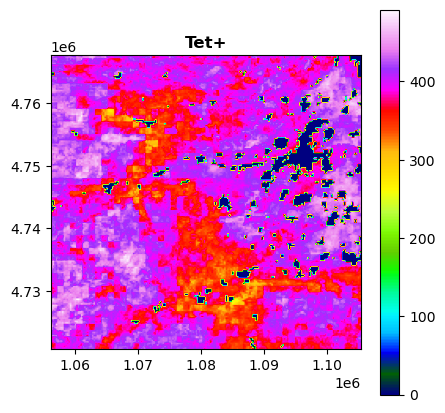

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
image = plot.show(silt05, title='Tet+', cmap='gist_ncar', ax=ax)
im = image.get_images()[0]
fig.colorbar(im, ax=ax)

In [17]:
silt05.crs

CRS.from_wkt('PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [18]:
dstCrs = {'init': 'EPSG:2154'}

In [19]:
transform, width, height = calculate_default_transform(silt05.crs,
                                                       dstCrs,
                                                       silt05.width, 
                                                       silt05.height, 
                                                       *silt05.bounds)

In [20]:
print(silt05.transform)

| 250.25, 0.00, 1056100.00|
| 0.00,-250.54, 4767500.00|
| 0.00, 0.00, 1.00|


In [21]:
print(transform)

| 277.01, 0.00, 648089.27|
| 0.00,-277.01, 6193585.09|
| 0.00, 0.00, 1.00|


In [22]:
kwargs = silt05.meta.copy()
kwargs.update({
        'crs': dstCrs,
        'transform': transform,
        'width': width,
        'height': height
    })

In [23]:
dstRst = rio.open('./tet/tet_silt_0-5cm_mean_Lambert.tif', 'w', **kwargs)

In [24]:
for i in range(1, silt05.count + 1):
    reproject(
        source=rio.band(silt05, i),
        destination=rio.band(dstRst, i),
        #src_transform=srcRst.transform,
        src_crs=silt05.crs,
        #dst_transform=transform,
        dst_crs=dstCrs,
        resampling=Resampling.nearest)

In [25]:
dstRst.close()

In [26]:
silt05 = rio.open('./tet/tet_silt_0-5cm_mean_Lambert.tif', driver="GTiff")

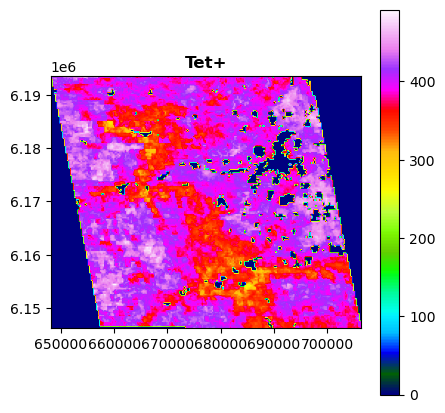

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
image = plot.show(silt05, title='Tet+', cmap='gist_ncar', ax=ax)
im = image.get_images()[0]
fig.colorbar(im, ax=ax)

In [28]:
_Z = np.flipud(silt05.read(1).astype(float))  # so that y is ascending

In [29]:
ny, nx = _Z.shape

In [30]:
dx = silt05.transform[0]
dy = silt05.transform[4]
ul = (silt05.transform[2], silt05.transform[5])

x = np.linspace(ul[0], ul[0] + dx * (nx -1), nx)
y = np.linspace(ul[1] + dy * (ny -1), ul[1], ny)  # so that y is ascending
_X, _Y = np.meshgrid(x, y, indexing='ij')

In [31]:
interp = RegularGridInterpolator((y, x), _Z)

In [32]:
Z = interp((Y, X))

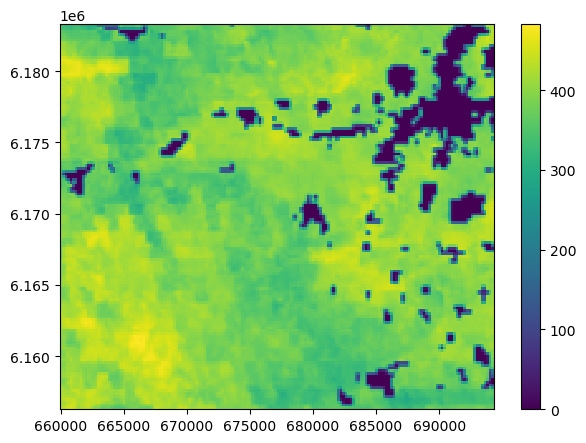

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(X, Y, Z)
plt.colorbar()

In [34]:
Z[np.isnan(dem)] = np.nan

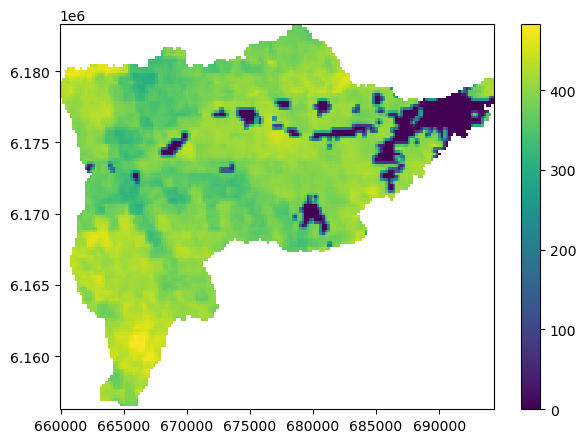

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(X, Y, Z)
plt.colorbar()

### Median or mean grain size for this layer

In [38]:
np.nanmedian(Z)

392.036842404044

In [37]:
np.nanmean(Z)

361.9088525766689

In [42]:
os.remove('./tet/tet_silt_0-5cm_mean_Lambert.tif')

### Run through the different clasts and depths to get a mean

In [43]:
sizes = ['0-5cm', '5-15cm', '15-30cm']
for size in sizes:

    cov_id = f'silt_{size}_mean'
    response = wcs.getCoverage(
        identifier=[cov_id], 
        crs='http://www.opengis.net/def/crs/EPSG/0/152160',
        subsets=subsets, 
        resx=250, resy=250, 
        format=silt_0_5.supportedFormats[0])
    with open(f'./tet/tet_silt_{size}_mean.tif', 'wb') as file:
        file.write(response.read())

In [47]:
silt_mean = []

for size in sizes:
    silt = rio.open(f'./tet/tet_silt_{size}_mean.tif', driver="GTiff")

    # Change projection
    dstRst = rio.open(f'./tet/tet_silt_{size}_mean_Lambert.tif', 'w', **kwargs)
    for i in range(1, silt.count + 1):
        reproject(
            source=rio.band(silt, i),
            destination=rio.band(dstRst, i),
            src_crs=silt.crs,
            dst_crs=dstCrs,
            resampling=Resampling.nearest)
    dstRst.close()
        
    # Read and flip new projection
    silt = rio.open(f'./tet/tet_silt_{size}_mean_Lambert.tif', driver="GTiff")
    _Z = np.flipud(silt.read(1).astype(float))

    # Inerpolate from the coordinates from the 0-5cm silt grid as all the grids have the same coordinates
    interp = RegularGridInterpolator((y, x), _Z)
    Z = interp((Y, X))
    Z[np.isnan(dem)] = np.nan
    silt_mean.append(np.nanmean(Z))

here
here
here


In [48]:
silt_mean

[361.9088525766689, 366.54197757721437, 345.7428788671138]

In [49]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/sand.map',
                         version='2.0.1')

In [50]:
print(list(wcs.contents))

['sand_0-5cm_Q0.05', 'sand_0-5cm_Q0.5', 'sand_0-5cm_Q0.95', 'sand_0-5cm_mean', 'sand_0-5cm_uncertainty', 'sand_5-15cm_Q0.5', 'sand_5-15cm_Q0.05', 'sand_5-15cm_Q0.95', 'sand_5-15cm_mean', 'sand_5-15cm_uncertainty', 'sand_15-30cm_Q0.5', 'sand_15-30cm_Q0.05', 'sand_15-30cm_Q0.95', 'sand_15-30cm_mean', 'sand_15-30cm_uncertainty', 'sand_30-60cm_Q0.05', 'sand_30-60cm_Q0.5', 'sand_30-60cm_Q0.95', 'sand_30-60cm_mean', 'sand_30-60cm_uncertainty', 'sand_60-100cm_Q0.5', 'sand_60-100cm_Q0.05', 'sand_60-100cm_Q0.95', 'sand_60-100cm_mean', 'sand_60-100cm_uncertainty', 'sand_100-200cm_Q0.05', 'sand_100-200cm_Q0.5', 'sand_100-200cm_Q0.95', 'sand_100-200cm_mean', 'sand_100-200cm_uncertainty']


In [51]:
sizes = ['0-5cm', '5-15cm', '15-30cm']
for size in sizes:

    cov_id = f'sand_{size}_mean'
    response = wcs.getCoverage(
        identifier=[cov_id], 
        crs='http://www.opengis.net/def/crs/EPSG/0/152160',
        subsets=subsets, 
        resx=250, resy=250, 
        format=silt_0_5.supportedFormats[0])
    with open(f'./tet/tet_sand_{size}_mean.tif', 'wb') as file:
        file.write(response.read())

In [63]:
sand_mean = []

for size in sizes:
    sand = rio.open(f'./tet/tet_sand_{size}_mean.tif', driver="GTiff")

    # Change projection
    dstRst = rio.open(f'./tet/tet_sand_{size}_mean_Lambert.tif', 'w', **kwargs)
    for i in range(1, sand.count + 1):
        reproject(
            source=rio.band(sand, i),
            destination=rio.band(dstRst, i),
            src_crs=silt.crs,
            dst_crs=dstCrs,
            resampling=Resampling.nearest)
    dstRst.close()
        
    # Read and flip new projection
    sand = rio.open(f'./tet/tet_sand_{size}_mean_Lambert.tif', driver="GTiff")
    _Z = np.flipud(sand.read(1).astype(float))

    # Inerpolate from the coordinates from the 0-5cm silt grid as all the grids have the same coordinates
    interp = RegularGridInterpolator((y, x), _Z)
    Z = interp((Y, X))
    Z[np.isnan(dem)] = np.nan
    sand_mean.append(np.nanmean(Z))

In [64]:
sand_mean

[323.66751082183333, 326.54418597814424, 307.00172895757635]

### Bulk density

In [57]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/bdod.map',
                         version='2.0.1')

In [58]:
print(list(wcs.contents))

['bdod_0-5cm_Q0.5', 'bdod_0-5cm_Q0.05', 'bdod_0-5cm_Q0.95', 'bdod_0-5cm_mean', 'bdod_0-5cm_uncertainty', 'bdod_5-15cm_Q0.5', 'bdod_5-15cm_Q0.05', 'bdod_5-15cm_Q0.95', 'bdod_5-15cm_mean', 'bdod_5-15cm_uncertainty', 'bdod_15-30cm_Q0.5', 'bdod_15-30cm_Q0.05', 'bdod_15-30cm_Q0.95', 'bdod_15-30cm_mean', 'bdod_15-30cm_uncertainty', 'bdod_30-60cm_Q0.05', 'bdod_30-60cm_Q0.5', 'bdod_30-60cm_Q0.95', 'bdod_30-60cm_mean', 'bdod_30-60cm_uncertainty', 'bdod_60-100cm_Q0.05', 'bdod_60-100cm_Q0.5', 'bdod_60-100cm_Q0.95', 'bdod_60-100cm_mean', 'bdod_60-100cm_uncertainty', 'bdod_100-200cm_Q0.05', 'bdod_100-200cm_Q0.5', 'bdod_100-200cm_Q0.95', 'bdod_100-200cm_mean', 'bdod_100-200cm_uncertainty']


In [62]:
sizes = ['0-5cm', '5-15cm', '15-30cm']
for size in sizes:

    cov_id = f'bdod_{size}_mean'
    response = wcs.getCoverage(
        identifier=[cov_id], 
        crs='http://www.opengis.net/def/crs/EPSG/0/152160',
        subsets=subsets, 
        resx=250, resy=250, 
        format=silt_0_5.supportedFormats[0])
    with open(f'./tet/tet_bdod_{size}_mean.tif', 'wb') as file:
        file.write(response.read())

In [66]:
bdod_mean = []

for size in sizes:
    bdod = rio.open(f'./tet/tet_bdod_{size}_mean.tif', driver="GTiff")

    # Change projection
    dstRst = rio.open(f'./tet/tet_bdod_{size}_mean_Lambert.tif', 'w', **kwargs)
    for i in range(1, bdod.count + 1):
        reproject(
            source=rio.band(bdod, i),
            destination=rio.band(dstRst, i),
            src_crs=silt.crs,
            dst_crs=dstCrs,
            resampling=Resampling.nearest)
    dstRst.close()
        
    # Read and flip new projection
    bdod = rio.open(f'./tet/tet_bdod_{size}_mean_Lambert.tif', driver="GTiff")
    _Z = np.flipud(bdod.read(1).astype(float))

    # Inerpolate from the coordinates from the 0-5cm silt grid as all the grids have the same coordinates
    interp = RegularGridInterpolator((y, x), _Z)
    Z = interp((Y, X))
    Z[np.isnan(dem)] = np.nan
    bdod_mean.append(np.nanmean(Z))

In [67]:
bdod_mean

[112.76943444037524, 122.93674970846209, 127.2723247776121]

### Mass to volume fraction

In [69]:
mean_sand_mass = np.mean(sand_mean) / 1000
mean_silt_mass = np.mean(silt_mean) / 1000
rest_mass = 1 - mean_sand_mass - mean_silt_mass

print(rest_mass)

silt_density = 2.8
sand_density = 2.64
bulk_density = np.mean(bdod_mean) / 100

mean_sand_vol = mean_sand_mass * bulk_density / sand_density
mean_silt_vol = mean_silt_mass * bulk_density / silt_density
rest_vol = rest_mass * bulk_density / sand_density

print(f'Silt = {mean_silt_vol}, Sand = {mean_sand_vol}, Rest = {rest_vol}')

0.32286428840714965
Silt = 0.15472588523754519, Sand = 0.14623228198899643, Rest = 0.1479707045348817


#